In [1]:
import os
from collections import defaultdict
from IPython.display import Image, display
from typing import List, TypedDict

from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_mistralai import ChatMistralAI
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

from config import set_environment
from rag_models import RecipeSearch


In [2]:
set_environment()

In [3]:
mistral_llm = ChatMistralAI(model="mistral-small-latest")
chat_ollama = ChatOllama(
    model="cogito-2.1:671b-cloud",
    base_url="https://ollama.com",
    headers={"Authorization": f"Bearer {os.environ['OLLAMA_API_KEY']}"},
    temperature=0)

chat_groq = ChatGroq(
    model="openai/gpt-oss-20b",
    temperature=0,
    max_tokens=None,
)

In [86]:
from prompts import router_prompt
# Router
from rag_models import Route

structured_llm_router = mistral_llm.with_structured_output(Route)
route_prompt = ChatPromptTemplate.from_messages(
    [("system", router_prompt),
     ("human", "{question}")])
question_router = route_prompt | structured_llm_router

In [7]:
from prompts import meta_data_filtering_prompt

# query_filter
query_filtering_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", meta_data_filtering_prompt),
        ("human", "{question}"),
    ]
)
query_filtering_structured_llm = chat_groq.with_structured_output(RecipeSearch)
query_analyzer = query_filtering_prompt | query_filtering_structured_llm

In [8]:
from agentic_retriever_helper import RecipeRetriever

# retriever
recipe_retriever  = RecipeRetriever()

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cross-encoder/ms-marco-MiniLM-L-6-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Retriever loaded from disk.


In [17]:
from prompts import rag_answer_generation_prompt

# answer generation
rag_prmpt = ChatPromptTemplate.from_template(rag_answer_generation_prompt)
rag_chain = rag_prmpt | chat_ollama | StrOutputParser()

In [73]:
from rag_models import GradeList
from prompts import grader_prompt

grader_parser = JsonOutputParser(pydantic_object=GradeList)
grader_prmpt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a strict grading API that ONLY outputs JSON."
               " Do not include any preamble, introduction, or explanation outside of the JSON structure."),
    ("human", grader_prompt)
]).partial(formatting_instructions=grader_parser.get_format_instructions())


grader_llm = chat_ollama.with_structured_output(GradeList)
grader_chain = grader_prmpt_template | grader_llm

In [74]:
from rag_models import RedefinedQuery
from prompts import query_rewriter_prompt

parser = JsonOutputParser(pydantic_object=RedefinedQuery)
query_rewriter_prompt_template = ChatPromptTemplate.from_template(query_rewriter_prompt).partial(format_instructions=parser.get_format_instructions())
# rewriter_llm = chat_groq.with_structured_output(RedefinedQuery)
rewriter_chain = query_rewriter_prompt_template | chat_groq | parser

In [87]:
from typing import Literal
from langchain_core.messages import HumanMessage

class RecipeRagState(TypedDict):
    question:str
    recipe_metadata_filters: defaultdict[list]
    rag_response: str
    documents: List[str]
    filtered_documents: List[str]
    relaxed_filters : defaultdict[list]
    max_retries:int

def route_query(state):
    route = question_router.invoke(
       state["question"]
    )
    data_source = route.datasource
    print(f"Routing question to: {data_source}")
    return data_source

def generic_search(state):
    response = mistral_llm.invoke(input=[HumanMessage(state["question"])])   
    return {"documents": [response.content]}

def analyze_query(state):
    recipe_meta_data_result = query_analyzer.invoke({"question": state["question"]})
    meta_data_filters = recipe_meta_data_result.model_dump(exclude_none=True)
    if meta_data_filters.get("category") == "Other" :
        del meta_data_filters["category"]
    print(f"meta data filters from the query: {meta_data_filters}")    
    return {"recipe_metadata_filters": meta_data_filters}
    
def retrieve_from_vectorstore(state):
    print(f"Retrieving from vectorstore:")
    if "relaxed_filters" in state:
        meta_data_filters = state["relaxed_filters"]
    else:
        meta_data_filters = state["recipe_metadata_filters"]
    filter_dict = {}
    if len(meta_data_filters) > 1:
       filter_dict["$and"] = [{f:meta_data_filters[f]} for f in meta_data_filters]
    elif len(meta_data_filters) == 1:
        filter_dict = meta_data_filters
    else:
        filter_dict = None
    print(f"Filters: {filter_dict}")
    query_result = recipe_retriever.get_results(
        state["question"], 
        filter_dict
    )    
    re_ranked_docs = recipe_retriever.re_rank(state["question"],query_result)
    print(f"number of filtered docs: {len(re_ranked_docs)}")
    return {"documents": re_ranked_docs}

def grade_documents(state):   
    orig_docs = state["documents"]
    grader_output = grader_chain.invoke(
        {"question": state["question"], "documents": orig_docs})  
    if state["max_retries"] >= 1:
        threshold = 5
    else:
        threshold = 3
    matched_docs = []
    print(f"Grader output: {grader_output.scores}")
    for index,graded_doc in enumerate(grader_output.scores):
        if graded_doc.score >= threshold:
            matched_docs.append(orig_docs[index])
    return {"filtered_documents": matched_docs}

def should_requery(state) -> Literal["generate","re_query"]:
    if len(state["filtered_documents"]) > 0 or state["max_retries"] == 0:
        return "generate"
    else:
        return "re_query"

def re_query(state):
    rewriter_output = rewriter_chain.invoke({"question": state["question"], 
                                             "filters": state["recipe_metadata_filters"]})
    print(f"Requery Reasoning: {rewriter_output['reasoning']}")
    print(f"Requery relaxed_filters: {rewriter_output['relaxed_filters']}")
    original_dict = rewriter_output["relaxed_filters"]
    if original_dict["category"] == "Other" :
        del original_dict["category"]
    meta_data_filters = {f_name: f_value for f_name, f_value in original_dict.items() if f_value is not None}
    max_retries = state["max_retries"] - 1
    return {"relaxed_filters": meta_data_filters, "max_retries": max_retries}

    
def generate_answer(state):
    if "filtered_documents" in state:
        docs = state["filtered_documents"]
    else:
        docs = state["documents"]
    if len(docs) > 5:
        limited_docs = docs[0:5]
    else:
        limited_docs = docs
    rag_response = rag_chain.invoke({"context": limited_docs, "question": state["question"]})
    return {"rag_response": rag_response}    

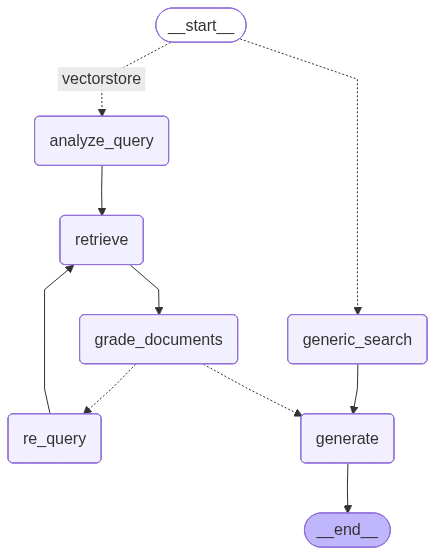

In [88]:
from langgraph.constants import START, END
from langgraph.graph import StateGraph

recipe_rag = StateGraph(RecipeRagState)

recipe_rag.add_node("generic_search", generic_search) 
recipe_rag.add_node("analyze_query", analyze_query) 
recipe_rag.add_node("retrieve", retrieve_from_vectorstore) 
recipe_rag.add_node("grade_documents", grade_documents)
recipe_rag.add_node("re_query", re_query) 
recipe_rag.add_node("generate", generate_answer)  

recipe_rag.add_conditional_edges(START, route_query, {
    "generic_search": "generic_search",
    "vectorstore": "analyze_query",
})
recipe_rag.add_edge("generic_search","generate")
recipe_rag.add_edge("analyze_query","retrieve")
recipe_rag.add_edge("retrieve","grade_documents")
recipe_rag.add_conditional_edges("grade_documents", should_requery)
recipe_rag.add_edge("re_query", "retrieve")
recipe_rag.add_edge("generate",END)
graph = recipe_rag.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [89]:
from pprint import pprint
generic_questions = ["How to boil an egg?", "What is the smoking point of oil?", "How does salt enhance flavour of a dish?"]
recipe_questions = ["Quick and healthy breakfast",
                    "lunch no-cook salad with citrus and beet",
                    "vegan gluten free pasta nut free",
                    "What is the use of corn in Tamale Bake?",
                    "How many eggs are required in Mom's Meat Loaf recipe?",
                    "Hearty seafood stew recipe",
                    "How make light dessert frosting?"]
for output in graph.stream(input=RecipeRagState(question="How make light dessert frosting?", max_retries=1)):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        pprint(value, indent=2, width=80, depth=None)
    pprint(f"{'='*80}")
pprint(value["rag_response"])

Routing question to: generic_search
"Node 'generic_search':"
{ 'documents': [ 'A light and fluffy dessert frosting can be made using simple '
                 'ingredients and techniques. Here are a few easy recipes for '
                 'different types of light frostings:\n'
                 '\n'
                 '### **1. Whipped Cream Frosting (Light & Airy)**\n'
                 '**Ingredients:**\n'
                 '- 1 cup heavy whipping cream (cold)\n'
                 '- 2–3 tbsp powdered sugar (adjust to taste)\n'
                 '- 1 tsp vanilla extract (or other flavoring)\n'
                 '- Optional: 1 tbsp mascarpone or cream cheese for stability\n'
                 '\n'
                 '**Instructions:**\n'
                 '1. Chill a mixing bowl and beaters for 10 minutes in the '
                 'freezer.\n'
                 '2. Whip the cold heavy cream on medium-high speed until soft '
                 'peaks form.\n'
                 '3. Gradually add powde

In [70]:
value["rag_response"]

'1) Roasted Beet And Orange Salad With Honey Orange Dressing  \n[DIETARY NOTE]: This recipe requires cooking the beets, which does not fully match the "no-cook" request. However, the rest of the salad assembly is no-cook. For a truly no-cook version, use pre-cooked beets.  \nPrep/Cook Time: 1 hour (for roasting beets) + prep time  \nIngredients:  \n- 4 whole Small Beets  \n- 2 whole Large Oranges  \n- 1/4 cups Walnuts  \n- 8 cups Mixed Baby Lettuces  \n- 1 whole Large Orange, Juice And Zest (for dressing)  \n- 1 Tablespoon Liquid Honey  \n- 1 teaspoon Dijon Mustard  \n- 1 Tablespoon Olive Oil  \n- Salt And Pepper, to taste  \n\nDirections:  \n1. Preheat the oven to 350 F.  \n2. Thoroughly wash the beets. Wrap the beets in an aluminum foil or parchment paper packet and place the packet on a cookie sheet. Bake the beets for 1 hour or until tender. Remove from the oven, unwrap the beets and let them cool. Once cooled, cut the ends off the beets and peel them carefully. Slice into 1/8" sli